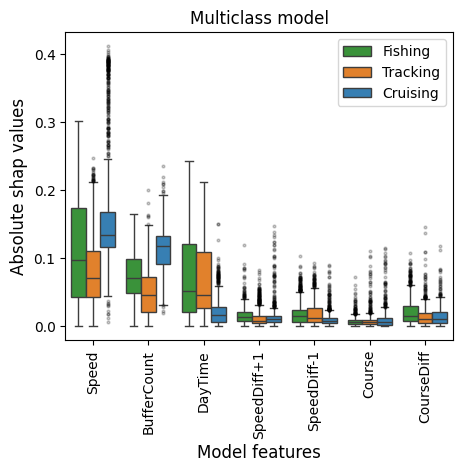

In [1]:
import joblib
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#CHOOSE THE MODEL EVALUATED
modelRunning = 'binaryModel'
modelRunning = 'multiClassModel'

#1. Get fitted model
MLmodel = joblib.load('results/' + modelRunning + '/fittedModel_' + modelRunning +'.pkl')

#2. Extract shap values
x_train = pd.read_csv('data/' + modelRunning + '/x_train.csv')
explainer = shap.TreeExplainer(MLmodel.best_estimator_)
shap_values = explainer(x_train) #for categorical response variable there are two sets of shap values (660obs x 7features each). I guess one for each label(?)

beautyfullFeatureNames = ['Speed', 'Course', 'CourseDiff', 'SpeedDiff+1','SpeedDiff-1',
                 'DayTime','BufferCount']
shap_values.feature_names = beautyfullFeatureNames

#3. Transpose matrix for boxplot
if modelRunning == 'multiClassModel':
    shap0df = pd.DataFrame(data=np.abs(shap_values.values[:,:,0]),
                columns=shap_values.feature_names)
    shap1df = pd.DataFrame(data=np.abs(shap_values.values[:,:,1]),
                columns=shap_values.feature_names)
    shap2df = pd.DataFrame(data=np.abs(shap_values.values[:,:,2]),
                columns=shap_values.feature_names)
    len(shap2df)
    shap2df
    shapDfDict = {'Fishing':shap1df,'Tracking':shap0df,  'Cruising':shap2df}
    hue_order_plot = ['Fishing', 'Tracking', 'Cruising'] #I define this variable here to reduce code afterwards
    colorDict = {'Cruising':'#2283C8', 'Tracking':'#ff7f0e', 'Fishing':'#2ca02c'}
    title = 'Multiclass model'
    

if modelRunning == 'binaryModel':
    shap0df = pd.DataFrame(data=np.abs(shap_values.values[:,:,0]),
                columns=shap_values.feature_names)
    shap1df = pd.DataFrame(data=np.abs(shap_values.values[:,:,1]),
                columns=shap_values.feature_names)
    shapDfDict = {'Tracking-Cruising':shap0df, 'Fishing':shap1df}
    hue_order_plot = ['Fishing', 'Tracking-Cruising'] #I define this variable here to reduce code afterwards
    colorDict = {'Fishing':'#2ca02c', 'Tracking-Cruising':'#C82937'}
    title = 'Binary model'

transposedShap = {}
for shapDf in shapDfDict:
    df_dict = {}
    for feature in shap_values.feature_names:
        shapDfDict[shapDf]['Operation'] = shapDf
        shapDfDict[shapDf]['Feature'] = 'holi'
        df = shapDfDict[shapDf][[feature, 'Feature', 'Operation']].copy()
        df['Feature'] = feature
        df = df.rename(columns={feature:'Shap'})
        #add variable value for scatterplots?
        df_dict[feature] = df
    transposedShap[shapDf] = pd.concat(df_dict.values())
shapFinalDF = pd.concat(transposedShap.values())
shapFinalDF
#4. Boxplot
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.boxplot(data=shapFinalDF, x='Feature', y='Shap', hue='Operation',
            order=['Speed', 'BufferCount', 'DayTime', 'SpeedDiff+1', 'SpeedDiff-1', 
                    'Course', 'CourseDiff'],
            hue_order=hue_order_plot,
            palette = colorDict,
            flierprops = dict(markersize=2, alpha=0.2, markerfacecolor='black', markeredgecolor=None)
            )
plt.xticks(rotation=90)
plt.title(title)
ax.set_xlabel("Model features",fontsize=12)
ax.set_ylabel("Absolute shap values",fontsize=12)
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
ax.legend_.set_title(None)
plt.savefig('results/' + modelRunning + '/shapValues/shapBoxplot.png', bbox_inches='tight', dpi=300)

In [8]:
pal = sns.color_palette()
pal
print(pal.as_hex())
colorDict = {'N':'#1f77b4', 'A':'#ff7f0e', 'C':'#2ca02c', 'AN':'#d62728'}

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


'Speed'

'BufferCount'

'DayTime'

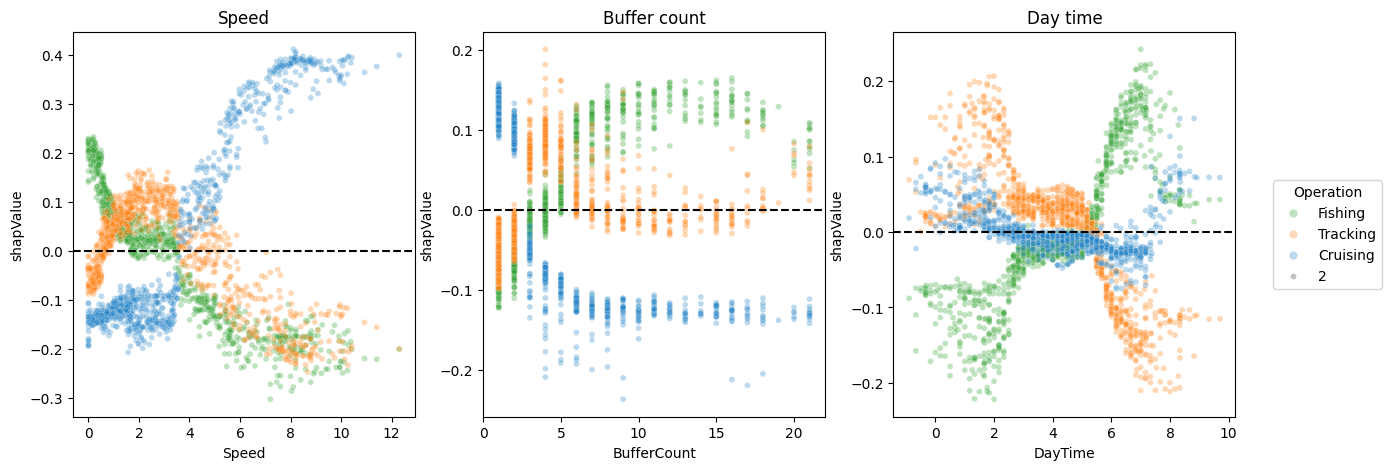

In [68]:
#5. Scatterplots
features = ['Speed', 'BufferCount', 'DayTime']
if modelRunning == 'binaryModel':
    for feature in features:
        feature
        shapAN = shap_values[:,feature,0].values
        ANdata = shap_values[:,feature,0].data
        shapC = shap_values[:,feature,1].values
        Cdata = shap_values[:,feature,1].data

        shapScatterDF = pd.concat([pd.DataFrame({'VessOp':'C', 'shapValue':shapC, feature:Cdata}),
                                   pd.DataFrame({'VessOp':'AN', 'shapValue':shapAN, feature:ANdata})])
        if feature == 'DayTime':
            shapScatterDF['DayTime'] = shapScatterDF['DayTime']-12
        fig, ax = plt.subplots(figsize=(6,6))
        sns.scatterplot(shapScatterDF, x=feature, y='shapValue', hue='VessOp', alpha=0.5)
        plt.axhline(y=0, linestyle='--', color='black')
        plt.legend(title='Operation')
        #sns.regplot(shapScatterDF.loc[shapScatterDF['VessOp'] =='AN'], x=feature, y='shapValue', order=3, line_kws=dict(color="orange"), scatter=False)
        #sns.regplot(shapScatterDF.loc[shapScatterDF['VessOp'] =='C'], x=feature, y='shapValue', order=3, line_kws=dict(color="blue"), scatter=False)
        ax.set_ylabel("Shap values",fontsize=12)
        fig.savefig('results/'+ modelRunning + '/shapValues/scatterplot_' + feature + '.png', bbox_inches='tight')
        

if modelRunning == 'multiClassModel':
    for feature in features:
        feature
        shapA = shap_values[:,feature,0].values
        Adata = shap_values[:,feature,0].data
        shapC = shap_values[:,feature,1].values
        Cdata = shap_values[:,feature,1].data
        shapN = shap_values[:,feature,2].values
        Ndata = shap_values[:,feature,2].data

        shapScatterDF = pd.concat([pd.DataFrame({'VessOp':'Fishing', 'shapValue':shapC, feature:Cdata}),
                                   pd.DataFrame({'VessOp':'Tracking', 'shapValue':shapA, feature:Adata}),
                                   pd.DataFrame({'VessOp':'Cruising', 'shapValue':shapN, feature:Ndata})])
        dfName = feature + 'df' 
        if feature == 'Speed': speedDF = shapScatterDF
        if feature == 'BufferCount': bufferCountDF = shapScatterDF
        if feature == 'DayTime':
            shapScatterDF['DayTime'] = shapScatterDF['DayTime']-12
            dayTimeDF = shapScatterDF
    
    colormapping = dict(Fishing='#2ca02c', Tracking='#ff7f0e', Cruising='#2283C8')
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    sns.scatterplot(ax = axes[0], x=speedDF.Speed, y=speedDF.shapValue, hue=speedDF.VessOp, palette=colormapping, alpha=0.3, size=2).axhline(y=0, linestyle='--', color='black')
    sns.scatterplot(ax = axes[1], x=bufferCountDF.BufferCount, y=bufferCountDF.shapValue, palette=colormapping, hue=bufferCountDF.VessOp, alpha=0.3, size=2).axhline(y=0, linestyle='--', color='black')
    sns.scatterplot(ax = axes[2], x=dayTimeDF.DayTime, y=dayTimeDF.shapValue, hue=dayTimeDF.VessOp, palette=colormapping, alpha=0.3, size=2).axhline(y=0, linestyle='--', color='black')
    for axNum in range(0,3): axes[axNum].get_legend().remove()
    axes[0].title.set_text('Speed')
    axes[1].title.set_text('Buffer count')
    axes[2].title.set_text('Day time')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', title='Operation')
    fig.savefig('results/'+ modelRunning + '/shapValues/scatterplot.png', bbox_inches='tight')
